# Idea
Do some feature ranking. 

**BUT**: SYSTE needs addional feature engineering.

**REMARKS**: addional parameter to show which version of system (0:old-simple bow; 1: process-syscall info; 2: 2-gram)

| **Possible DataSources** |
| --- |
| SYS_data |
| KERN_data |
| FLS_data |
| RES_data |
| block_data |
| network_data |
| entropy_data |


In [1]:
DATA_SOURCE = "SYS_data"
DEVICE_SOURCE = "Heqing_device2"

In [17]:
from enum import Enum

class SystemVersion(Enum):
    OLDxBOW = 'old-bow'
    OLDxBOWxWithoutMinMax = 'old-bow-without-min-max'
    PROCESSxINFO = 'process-info'
    TWOxGRAM = '2-gram'

VERSION = SystemVersion.OLDxBOWxWithoutMinMax

In [4]:
from pathlib import Path

import numpy as np
import pandas as pd

In [5]:
import sys
repo_base_path = Path("./../").resolve()
assert str(repo_base_path).endswith("csg_is"), f"{repo_base_path} is not a valid path to the CSG_IS repository" 

sys.path.append(str(repo_base_path))

from py_dataset import get_all_files_df
from py_dataset import read_in_files
from py_dataset import feature_plotting
from py_dataset import feature_selection

from py_dataset import sys_func
# from py_dataset import net_feature_engineering

# Loading Sys Data

##### 1. normal: bow

In [9]:
if VERSION != SystemVersion.OLDxBOW:
    raise NotImplementedError("Only OLD_BOW is implemented")


file_path = Path('/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/merged_data.npz')
assert file_path.exists(), 'Data not found'

with np.load(file_path, allow_pickle=True) as npz:
    print(npz.files)
    X = npz['arr_0']
print(X.shape)

vectorizer = sys_func.create_CountVectorizer()
cols = vectorizer.get_feature_names_out()
cols = np.append(cols, [['timestamp'], ['label']])
print (cols.shape)
df = pd.DataFrame(X, columns=cols)
df.set_index('timestamp', inplace=True)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

vectors = df.copy()
print(vectors.shape)
vectors.head(1)

['arr_0']
(11428, 162)
Loaded set: ('accept', 'accept4', 'access', 'add_key', 'adjtimex', 'bind', 'brk', 'capget', 'capset', 'chdir', 'chmod', 'chown32', 'clock_gettime', 'clone', 'close', 'connect', 'dup', 'dup2', 'dup3', 'epoll_create1', 'epoll_ctl', 'epoll_wait', 'eventfd2', 'execve', 'exit', 'exit_group', 'faccessat', 'fadvise64_64', 'fallocate', 'fchdir', 'fchmod', 'fchmodat', 'fchown32', 'fcntl64', 'fgetxattr', 'flistxattr', 'flock', 'fsetxattr', 'fstat64', 'fstatat64', 'fstatfs64', 'fsync', 'ftruncate64', 'futex', 'getcwd', 'getdents64', 'getegid32', 'geteuid32', 'getgid32', 'getgroups32', 'getpeername', 'getpgid', 'getpgrp', 'getpid', 'getppid', 'getpriority', 'getrandom', 'getresgid32', 'getresuid32', 'getsid', 'getsockname', 'getsockopt', 'gettid', 'gettimeofday', 'getuid32', 'getxattr', 'inotify_add_watch', 'ioctl', 'ioprio_get', 'ioprio_set', 'kcmp', 'keyctl', 'kill', 'lchown32', 'lgetxattr', 'llseek', 'lseek', 'lstat64', 'madvise', 'mkdir', 'mknod', 'mmap2', 'mount', 'mpro

,accept,accept4,access,add_key,adjtimex,bind,brk,capget,capset,chdir,...,umount2,uname,unlink,unlinkat,utimensat,wait4,waitid,write,writev,label
timestamp,,,,,,,,,,,,,,,,,,,,,
1.699708e+09,0.0,0.000017,0.001,0.0,0.0,0.000003,0.001033,0.00005,0.00002,0.000004,...,0.0,0.000261,0.000014,0.000008,0.0,0.000495,0.000015,0.029428,0.000004,6_beurk


##### 2. using process-sys_call information

In [10]:
if VERSION != SystemVersion.PROCESS_INFO:
    raise NotImplementedError("Only PROCESS_INFO is Run here")


from scipy.sparse import csr_matrix, vstack, hstack, save_npz, load_npz
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
import pickle
from sklearn.feature_selection import mutual_info_classif


data_path = Path(
    '/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/advanced')
assert data_path.exists()

def load_and_combine_npz_sparse(path):
    output_array = None

    for npz_file in path.glob("*.npz"):
        sparse_array = load_npz(npz_file)

        if output_array is None:
            output_array = sparse_array
        else:
            output_array = vstack((output_array, sparse_array))

    return output_array

path_to_read = data_path / 'merged_data_big_dataset'

merged = load_and_combine_npz_sparse(path_to_read)

vocab_file = data_path / "vocabulary_topK.pkl" #int(system_calls["calls"]) > 5 and float(process["cpu_usage"]) > 0 ==> 27GB and len 157711


if vocab_file.exists():
    with open(str(vocab_file), 'rb') as f:
        vocabulary = pickle.load(f)
    print("Loaded vocab:", vocabulary)

vectorizer = CountVectorizer(vocabulary=vocabulary)

X = merged[:, :-2]
Z = merged[:, -2:]

transformer = TfidfTransformer()
X_tf = transformer.fit_transform(X)
cols = vectorizer.get_feature_names_out()
label_encoder = sys_func.create_label_encoder_for_labels()

assert Z[:,-1:].shape[0] >0

vectors = hstack((X_tf, Z[:,-1:])) # add the labels => maybe runs out of memory => if so (maybe use low_variance before)

AttributeError: PROCESS_INFO

##### 3. using 2-grams of sys-calls

In [11]:
if VERSION != SystemVersion.TWO_GRAM:
    raise NotImplementedError("Only TWO_GRAM is Run here")


from sklearn.feature_extraction.text import CountVectorizer

file_path = Path('/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/merged_data_ngrams.npz')
assert file_path.exists(), 'Data not found'

data_path = Path(
    "/media/<User>/DC/IS_Data_Exploration_and_Feature_Engineering_for_an_IoT_Device_Behavior_Fingerprinting_Dataset/sys_system_calls_Heqing_device2/"
)
assert data_path.exists()
vocab_file = data_path / "vocabulary_ngrams.pkl"

if vocab_file.exists():
    with open(str(vocab_file), "rb") as f:
        vocabulary = pickle.load(f)

    print("Loaded set:", vocabulary)

vectorizer = CountVectorizer(vocabulary=vocabulary)

with np.load(file_path, allow_pickle=True) as npz:
    print(npz.files)
    X = npz['arr_0']
print(X.shape)

cols = vectorizer.get_feature_names_out()
cols = np.append(cols, [['timestamp'], ['label']])
print (cols.shape)
df = pd.DataFrame(X, columns=cols)
df.set_index('timestamp', inplace=True)

label_encoder = sys_func.create_label_encoder_for_labels()
df['label'] = label_encoder.inverse_transform(df['label'].values.astype(int))

vectors = df.copy()
print(vectors.shape)
vectors.head(1)

AttributeError: TWO_GRAM

#### Preprocessing

Max values for each column: [1.51974764e-04 1.00784891e-03 4.43725854e-02 1.61963587e-04
 7.71470699e-04 8.70988488e-04 2.26343115e-02 9.39706500e-04
 3.67454846e-04 4.19281674e-04 2.28441335e-03 3.20037820e-02
 4.90003942e-01 7.29598945e-03 8.36578263e-01 6.39105335e-03
 3.11009530e-03 7.06075144e-03 1.03857136e-04 3.63589687e-04
 6.44244285e-03 2.45895390e-02 6.17887421e-04 4.76534094e-03
 1.00856666e-04 6.54823833e-03 1.70228321e-03 6.39467546e-04
 3.25319567e-05 1.75498804e-04 9.60794037e-04 1.78334389e-04
 1.51166014e-03 8.48193308e-02 1.75498804e-04 4.26900686e-04
 6.87871046e-03 1.75498804e-04 3.35980621e-01 1.17167357e-02
 1.77463377e-04 7.11275767e-04 1.76500298e-03 1.42512331e-02
 2.21030435e-02 1.01873218e-01 1.32590985e-02 2.27544578e-02
 1.04289825e-01 2.89417212e-04 5.80870451e-03 1.77124165e-04
 5.62731777e-04 2.82079882e-01 8.95863208e-04 1.25299149e-03
 1.05208559e-02 7.69571501e-04 7.69571501e-04 1.77124165e-04
 2.65679811e-03 1.21545250e-02 5.34084115e-04 5.52990382e

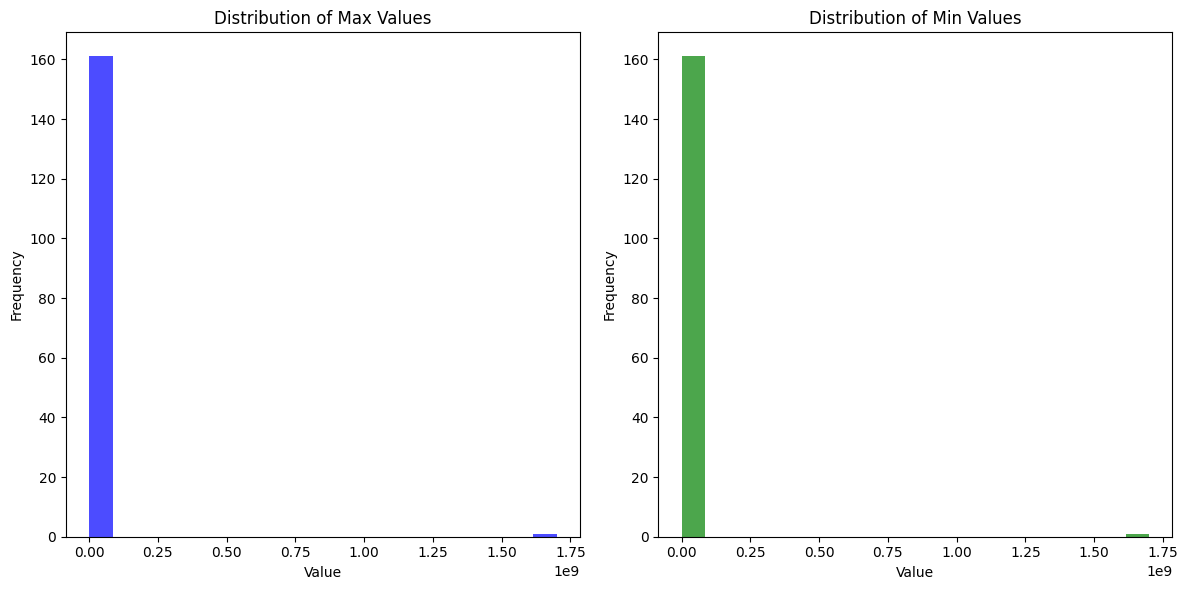

In [12]:
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt

sparse_matrix = sp.csr_matrix(X)
# Convert to CSC format for efficient column operations
sparse_matrix_csc = sparse_matrix.tocsc()

# Initialize arrays to hold max and min values
max_values = np.zeros(sparse_matrix.shape[1])
min_values = np.zeros(sparse_matrix.shape[1])

# Iterate through each column
for i in range(sparse_matrix.shape[1]):
    column = sparse_matrix_csc.getcol(i).data  # Extract the column data
    if column.size > 0:
        max_values[i] = column.max()
        min_values[i] = column.min()
    else:
        max_values[i] = 0  # or np.nan if you prefer to indicate no data
        min_values[i] = 0  # or np.nan

print("Max values for each column:", max_values)
print("Min values for each column:", min_values)

# Plot histograms
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(max_values, bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Max Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(min_values, bins=20, color='green', alpha=0.7)
plt.title('Distribution of Min Values')
plt.xlabel('Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [8]:
vectors.reset_index(inplace=True, drop=True)  # drops: "timestamp"

cols_to_exclude_from_scaling = ["label"]

vectors = feature_plotting.test_transform_all_to_numeric_columns(vectors, cols_to_exclude_from_scaling)
# vectors_scaled = feature_plotting.minmax_scale_features(vectors,
#                                                         remove_outliers_iqr_all_columns=False,
#                                                         cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

# vectors_robust_scaled = feature_plotting.minmax_scale_features(vectors,
#                                                                remove_outliers_iqr_all_columns=True,
#                                                                cols_to_exclude_from_scaling=cols_to_exclude_from_scaling)

In [13]:
X = vectors.drop(columns=["label"])
Y = vectors["label"]

# X_ROBUST = vectors_robust_scaled.drop(columns=["label"])

assert X.dropna().shape == X.shape, "X contains NaNs"

In [13]:
# print(X_ROBUST.dropna().shape, X_ROBUST.shape)

# X_ROBUST.dropna(inplace=True)
# Y_ROBUST = vectors_robust_scaled.dropna()["label"]

(3674, 160) (11428, 160)


#### Ranking

In [14]:
print(feature_selection.get_low_variance_features(X, threshold=0.0))
# print(f"{feature_selection.get_low_variance_features(X_ROBUST, threshold=0.0)}: Will be removed if outliers are removed")

['nan']


In [15]:
X.drop(columns=feature_selection.get_low_variance_features(X, threshold=0.0), inplace=True)
# X_ROBUST.drop(columns=feature_selection.get_low_variance_features(X_ROBUST, threshold=0.0), inplace=True)

In [16]:
scores_by_label = feature_selection.calculate_scores_by_label(X, Y)
scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()
singles = scores_by_label.groupby("feature")[[ "chi2", "f_classif", "mutual_info_classif"]].mean()

Label: 6_beurk
Label: 2_ransomware
Label: 1_normal
Label: 4_bashlite
Label: 8_bdvl
Label: 9_xmrig
Label: 7_backdoor
Label: 3_thetick
Label: 5_httpbackdoor


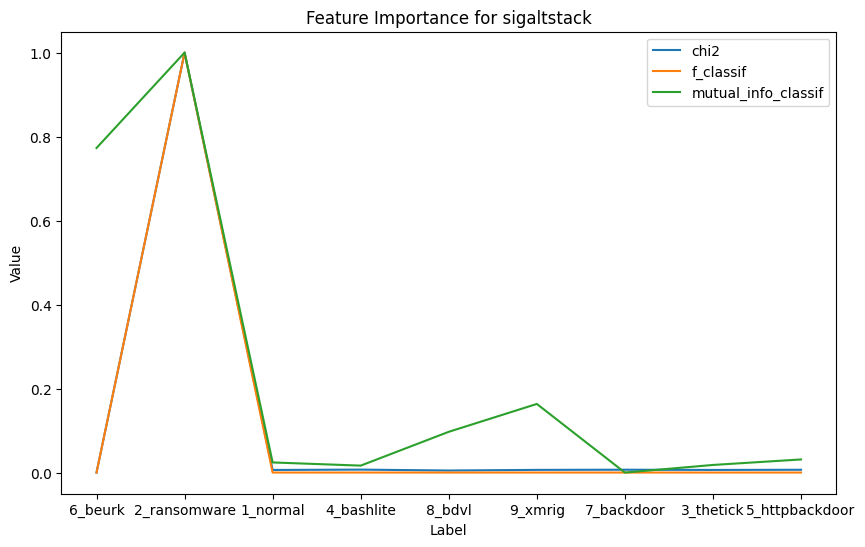

In [18]:
test_df = scores_by_label.copy()
feature_selection.sort_by_mean(test_df)
test_df.reset_index(inplace=True)
best_Feature = test_df.loc[0]["feature"]

feature_selection.plot_scores_by_label_single_plot_single_feature( scores_by_label, best_Feature)

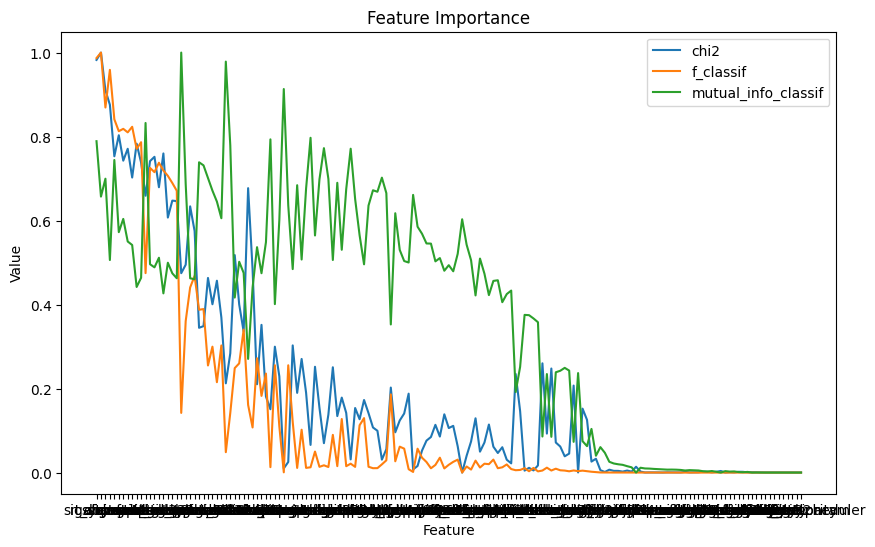

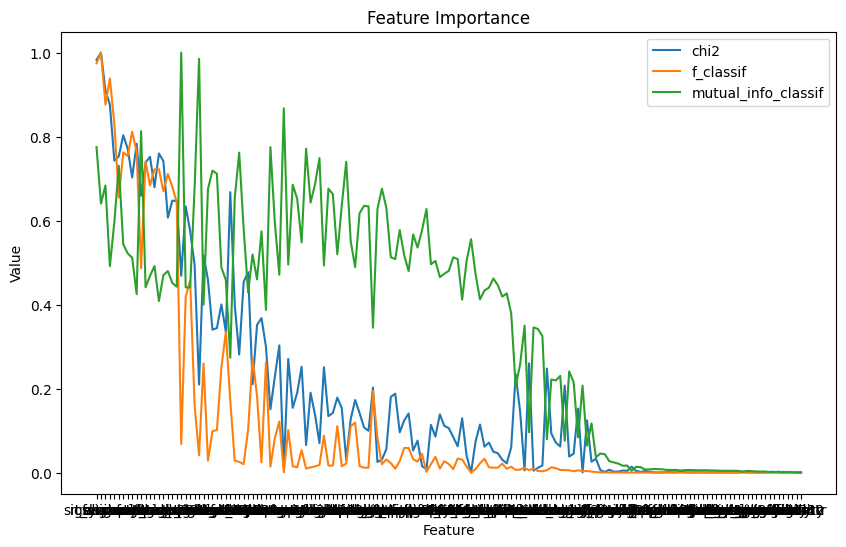

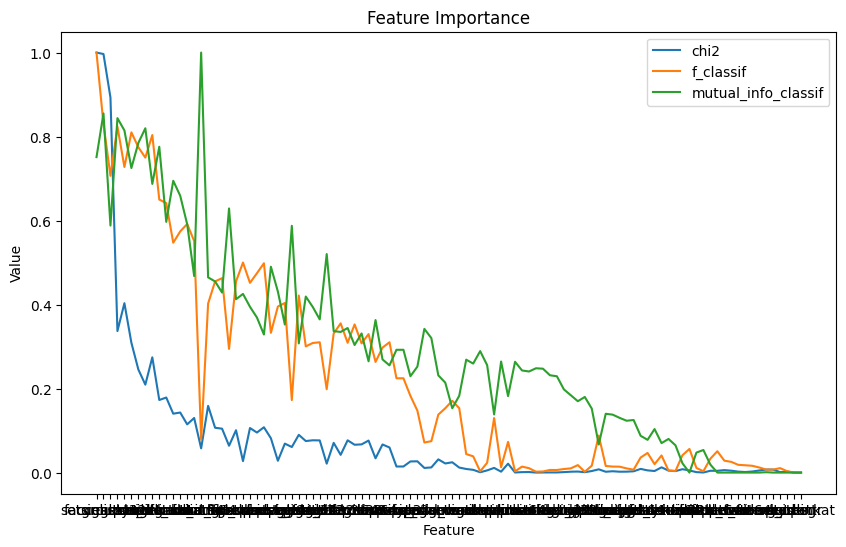

In [18]:
scores = feature_selection.calculate_scores(X, Y)
feature_selection.plot_single_scores(scores)

singles = singles.loc[scores["feature"].unique()]
singles = singles.reset_index()
feature_selection.plot_single_scores(singles)

scores_robust = feature_selection.calculate_scores(X_ROBUST, Y_ROBUST)
feature_selection.plot_single_scores(scores_robust)

2_ransomware
8_bdvl
9_xmrig
6_beurk
1_normal
5_httpbackdoor
3_thetick
4_bashlite
7_backdoor


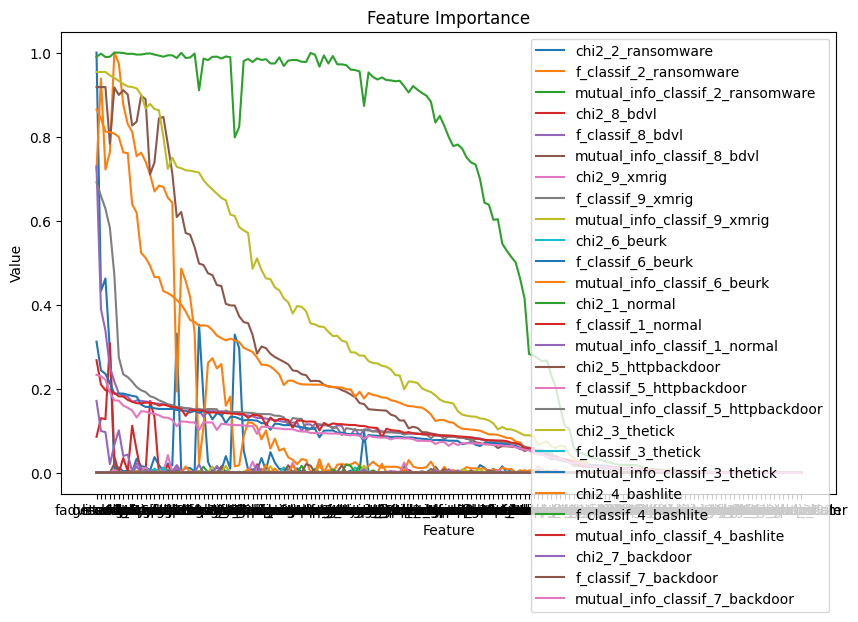

In [20]:
feature_selection.plot_scores_by_label_single_plot(scores_by_label)

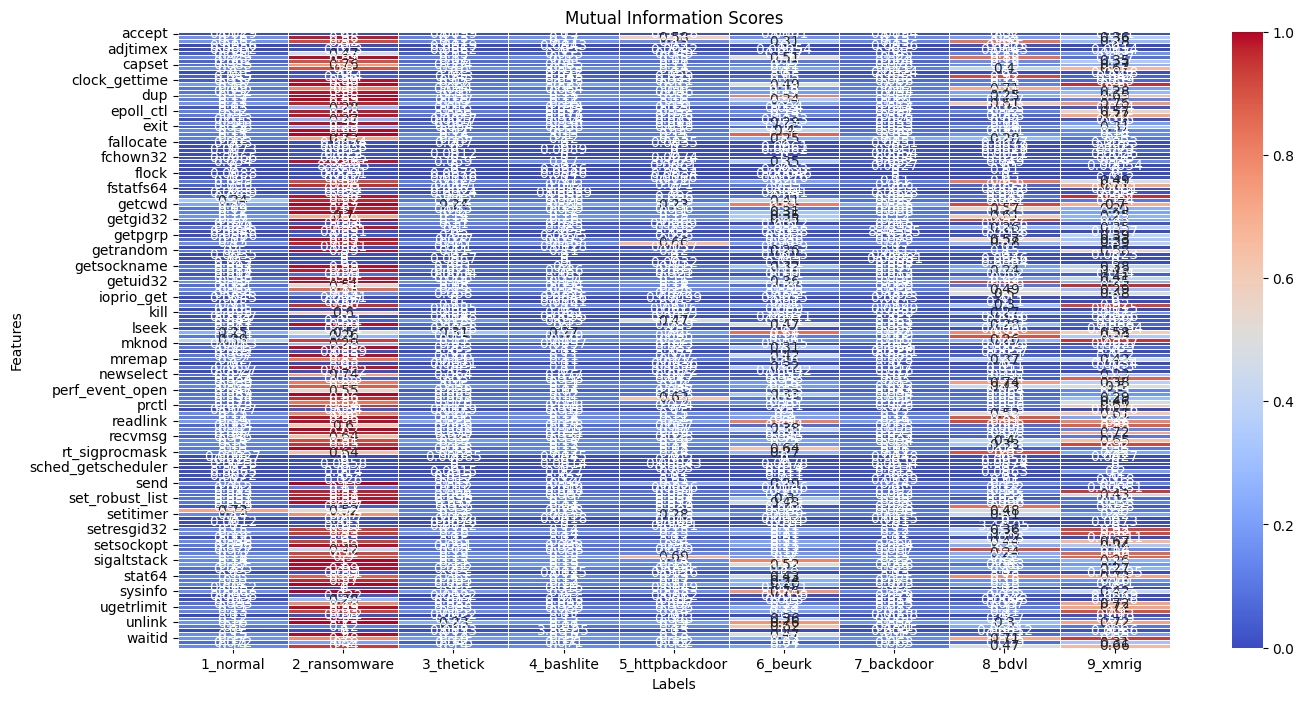

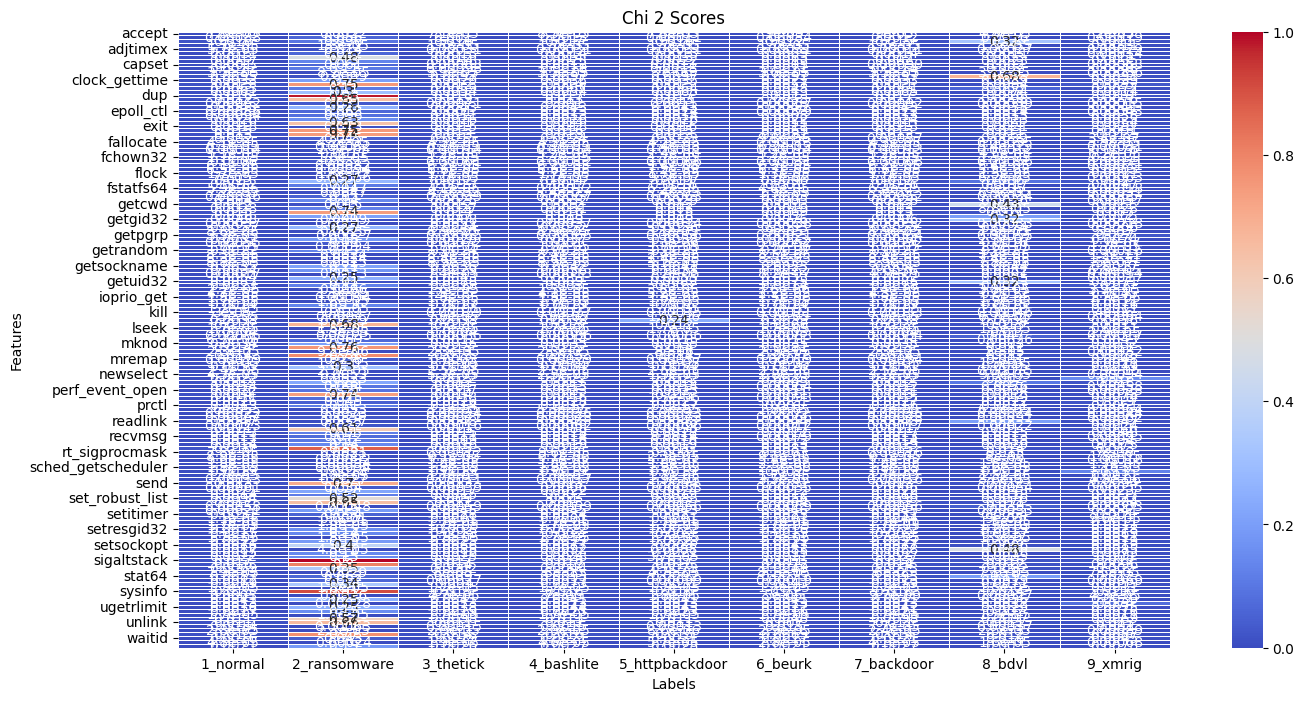

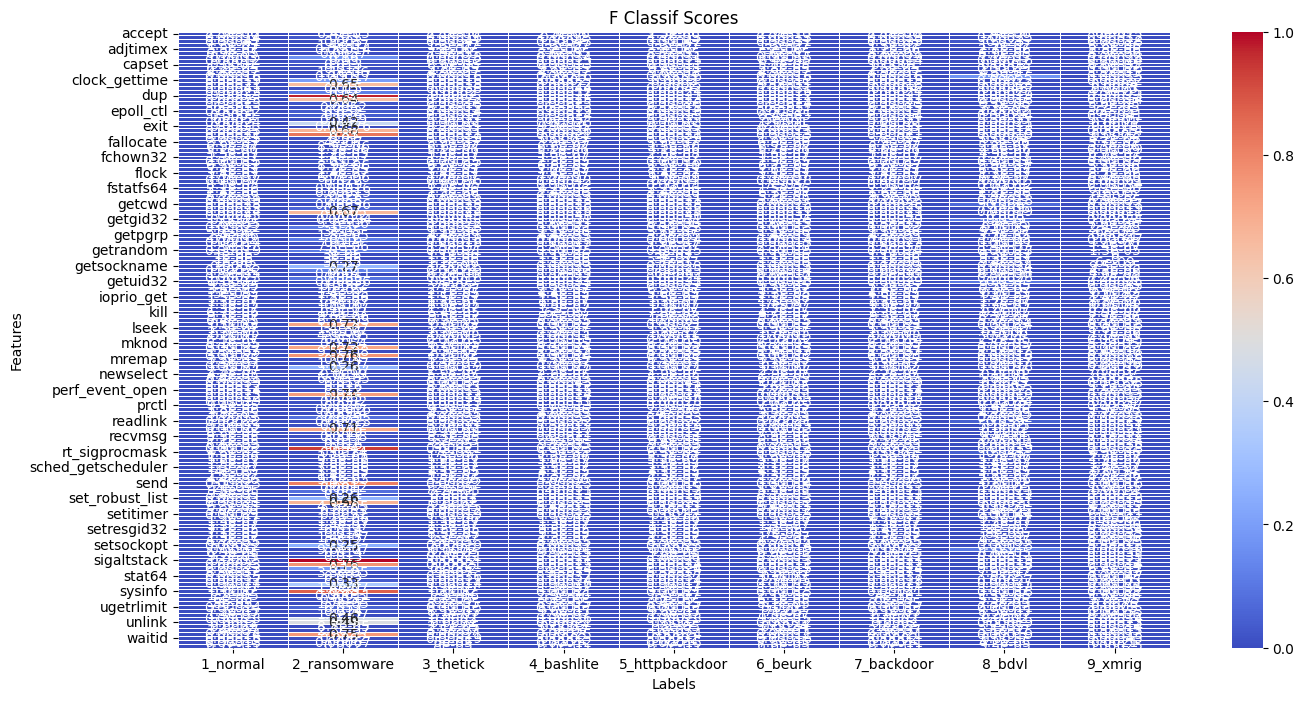

In [20]:
feature_selection.heatmap_scores_by_label_versus_features(scores_by_label)

In [21]:
# scores_by_label_robust = feature_selection.calculate_scores_by_label(X_ROBUST, Y_ROBUST)
# feature_selection.heatmap_scores_by_label_versus_features(scores_by_label_robust)

#### Storing scores (modified for sys)

In [22]:
output_dir = repo_base_path / "feature_selection" / "result"
output_file_X = output_dir / f"{DATA_SOURCE}{str(VERSION)}_{DEVICE_SOURCE}_featurescores.csv"
# output_file_X_ROBUST = output_dir / f"{DATA_SOURCE}{str(VERSION)}_{DEVICE_SOURCE}_featurescores_ROBUST.csv"

In [23]:
scores_by_label.to_csv(output_file_X, index=False)
# scores_by_label_robust.to_csv(output_file_X_ROBUST, index=False)